In [1]:
%matplotlib inline

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

In [2]:
import sys

sys.path.insert(0, 'modules/')
    
from chromosome_data_processor import * 
from lengths_data_processor import *

In [3]:
data = pd.read_csv('datasets/CytoScan.Segmental.Reports/OS001_events.txt', sep='\t', comment='#')

In [4]:
data = process_chromosome_data(data)

data

,Chromosome,Copy Number,Length,Start,End
0,1,3,1961264,3699709,5660972
1,1,3,1898488,6923109,8821596
3,1,3,3223208,12392108,15615315
15,1,3,1522222,60470133,61992354
22,1,3,13965171,69521787,83486957
...,...,...,...,...,...
764,Y,3,90619,25623467,25714085
765,Y,3,36116,25789995,25826110
766,Y,3,185678,26147446,26333123
767,Y,3,392040,27012136,27404175


In [5]:
lengths = pd.read_csv('datasets/hs37d5.fa.fai', sep='\t', header=None)

In [6]:
lengths = process_lengths_data(lengths)

lengths

,Length
Chromosome,
1,249250621
2,243199373
3,198022430
4,191154276
5,180915260
6,171115067
7,159138663
8,146364022
9,141213431


In [50]:
def split_chromosome_to_bins(chromosome_data, chromosome_len, bin_len=30000):
    bins = []
    for base in range(0, chromosome_len, bin_len):
        if chromosome_len - base < bin_len:  # last short bin
            curr_bin_len = chromosome_len - base
        else:
            curr_bin_len = bin_len
            
        _bin = np.full((curr_bin_len), 2)
        
        bin_start = base
        bin_end = base + bin_len
        
        for index, row in chromosome_data.iterrows():
            event_start = int(row['Start'])
            event_end = int(row['End'])
            
            if event_start < bin_start and event_end >= bin_start:
                update_start = 0
                if event_end < bin_end:
                    update_end = event_end - bin_start + 1
                else:
                    update_end = bin_end
                _bin[update_start:update_end] = row['Copy Number']
                
            elif event_start <= bin_end and event_end >= bin_end:
                update_end = bin_end
                if event_start > bin_start:
                    update_start = event_start - bin_start + 1
                else:
                    update_start = 0
                _bin[update_start:update_end] = row['Copy Number']
                    
            elif event_start >= bin_start and event_end < bin_end:
                update_start = event_start - bin_start + 1
                update_end = event_end - bin_start + 1
                _bin[update_start:update_end] = row['Copy Number']
        
        bin_avg = np.average(_bin)
        bins.append(bin_avg)
    
    return bins

In [8]:
chr6 = data[data['Chromosome'] == '6']

chr6

,Chromosome,Copy Number,Length,Start,End
179,6,1,32969007,0,32969006
184,6,1,25136920,33023971,58160890
191,6,1,48000997,61000000,109000996
195,6,4,5939,109000996,109006934
198,6,1,62108134,109006934,171115067


In [12]:
chr6_len = lengths.loc[['6']]['Length'].item()

chr6_len

171115067

In [51]:
bins = split_chromosome_to_bins(chr6, chr6_len)

In [53]:
def plot_bins(bins):
    fig, ax = plt.subplots(figsize=(20,10))
    ax.plot(bins, color='gray')
    ax.set_ylim([0, 4])
    ax.set_xlim([0, len(bins)])

    ax.axhline(y=2, color='k', dashes=(5, 5))

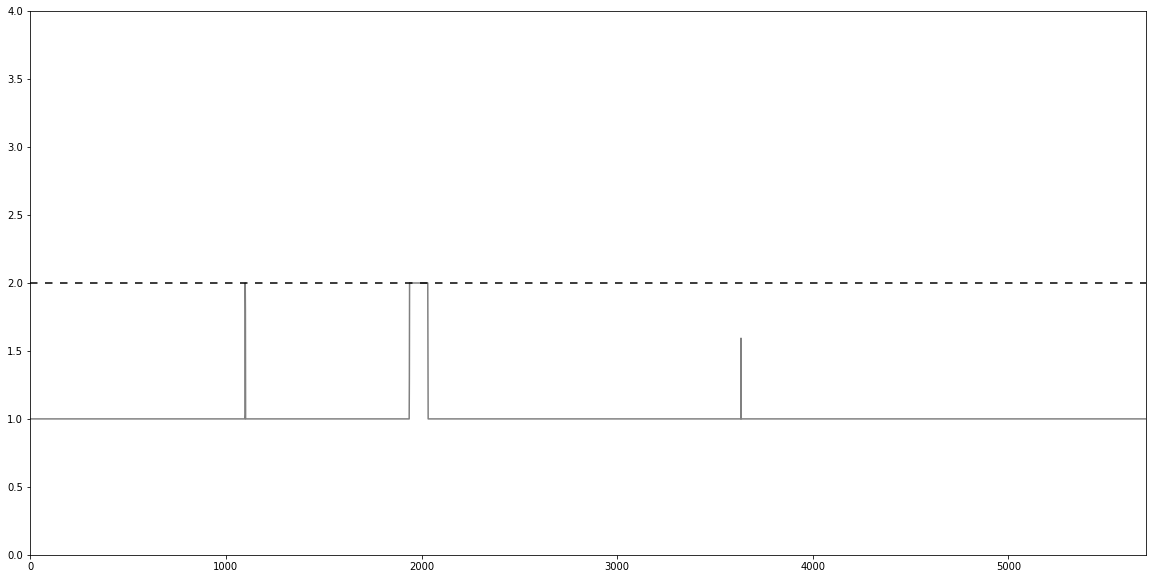

In [54]:
plot_bins(bins)